maryamm allahkhani
shaghayegh shafiee

In [1]:
import pickle
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from scipy.spatial import ConvexHull
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import random
import cv2



In [2]:
def load_dataset():
    image_pickle_file_path = 'images.pkl'
    label_pickle_file_path = 'label.pkl'

    with open(image_pickle_file_path, 'rb') as file:
        images = pickle.load(file)

    with open(label_pickle_file_path, 'rb') as file:
        labels = pickle.load(file)

    features = []
    # pixel_locations = []
    # hsv_values = []
    for image in images:
        n, m, _ = image.shape
        indices = np.indices((n, m))

        pixel_img = np.column_stack((indices[0].ravel(), indices[1].ravel()))
        # pixel_locations.append(pixel_img)
        
        hsv_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        
        hsv = hsv_image.reshape(n*m, -1)
        
        # hsv_values.append(hsv)
        feature_image = np.column_stack((hsv,pixel_img))
        features.append(feature_image)
    # return images, labels, pixel_locations, hsv_values , features
    return images, labels , features

In [3]:
# Classify the datapoints with the Random Forest Classifier
def classify(feature_vectors, labels):
    test_size = 0.2
    X_train, X_test, y_train, y_test = train_test_split(feature_vectors, labels, test_size=test_size, random_state=42)

    clf = RandomForestClassifier(n_estimators=100, random_state=42)

    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy * 100:.2f}%")

In [22]:

def extract_flower_parts(features):    
    numberCluster = 3      
    # Normalize saturation and brightness values 
    scaler = StandardScaler()     
     # Calculate the center of the image
    width = np.max(features[:, 3])
    height = np.max(features[:, 4])
    center_x =  width / 2
    center_y = height / 2
    
    # Calculate the horizontal and vertical space between each pixel and the center
    horizontal_space = np.abs(features[:, 3] - center_x)
    vertical_space = np.abs(features[:, 4] - center_y)
    # Normalize the new features
    horizontal_space_normalized = scaler.fit_transform(horizontal_space.reshape(-1, 1))
    vertical_space_normalized = scaler.fit_transform(vertical_space.reshape(-1, 1))
        
    # Define the number of components for GMM
    num_components = 3  # You can adjust this based on the complexity of the color distribution
    original_hue_values = features[:, 0].copy()
    # Fit GMM to the original hue values
    gmm = GaussianMixture(n_components=num_components)
    gmm.fit(original_hue_values.reshape(-1, 1))

    # Assign each pixel to the most likely cluster based on its hue value
    cluster_assignments = gmm.predict(original_hue_values.reshape(-1, 1))

    # Replace the original hue values with the cluster means
    arranged_hue_values = gmm.means_[cluster_assignments]

    normalized_features = scaler.fit_transform(features[:, 1:5])  
    normalized_hue_values =scaler.fit_transform(arranged_hue_values.reshape(-1, 1))      
    weighted_features = np.empty([len(normalized_features), 7])  
    weighted_features[:, 0] = normalized_hue_values.flatten() * 12
    weighted_features[:, 1] = normalized_features[:, 0] * 5
    weighted_features[:, 2] = normalized_features[:, 1] * 8
    weighted_features[:, 3] = normalized_features[:, 2] * 6
    weighted_features[:, 4] = normalized_features[:, 3] * 6
    weighted_features[:, 5] = horizontal_space_normalized.flatten() * 3  # adjusted weight for horizontal space
    weighted_features[:, 6] = vertical_space_normalized.flatten() * 3  # adjusted weight for vertical space
    

    kmeans = KMeans(n_clusters=numberCluster)          
    kmeans.fit(weighted_features)       
    cluster_labels = kmeans.predict(weighted_features)  
    
        
    labeled_pixels = []  
    pixels = []
    for i in range(len(features)):  
        pixel = [int(features[i][3]), int(features[i][4]), cluster_labels[i]]  
        labeled_pixels.append(pixel)  
        pixel2 = [int(features[i][0]), int(features[i][1]), int(features[i][2]), int(features[i][3]),int(features[i][4]), cluster_labels[i]]   
        pixels.append(pixel2)
      
    clusters = [[] for _ in range(numberCluster)]
    for i, pixel in enumerate(pixels):
        cluster_label = pixel[5]
        clusters[cluster_label].append([features[i][0], features[i][1], features[i][2], features[i][3],features[i][4], cluster_label])

    return labeled_pixels,clusters,width,height,len(features)




2 ways to cluster pixels but first is better now .

In [6]:
def show_cluster_image2(pixels, target_label,max_row,max_col):
   
 
    # Initialize an empty image with dimensions based on the maximum row and column values 
    image = np.zeros((max_row + 1, max_col + 1, 3), dtype=np.uint8) 
 
    # Assign unique colors to each cluster label excluding target label
    label_colors = {} 
    for pixel in pixels: 
        _, _, label = pixel 
        if label not in label_colors:
            if label == target_label:
                label_colors[label] = np.array([255, 0, 0], dtype=np.uint8)
            else:
                while True:
                    color = np.random.randint(0, 256, size=3, dtype=np.uint8)
                    if not np.array_equal(color, [255, 0, 0]): # Avoid red
                        label_colors[label] = color
                        break
 
    # Fill the image pixels with the corresponding cluster label color 
    for pixel in pixels: 
        row, col, label = pixel 
        color = label_colors[label] 
        image[row, col] = color 
    # Display the image 
    plt.imshow(image) 
    plt.axis('off') 
    plt.show()


In [7]:
import numpy as np

from skimage import exposure
from scipy.spatial import distance

def calculate_color_difference(cluster, other_cluster):
    
    target_hue_values = np.array(cluster)[:, 0]  # Extract hue values
    
    other_hue_values = np.array(other_cluster)[:, 0]  # Extract hue values
   
    # Compute histograms
    hist_pixels, _ = exposure.histogram(target_hue_values)
    hist_other_pixels, _ = exposure.histogram(other_hue_values)
    

    # Normalize histograms
    hist_pixels_norm = hist_pixels / np.sum(hist_pixels)
    hist_other_pixels_norm = hist_other_pixels / np.sum(hist_other_pixels)
    
    # Calculate histogram difference score
    color_difference = distance.euclidean(hist_pixels_norm, hist_other_pixels_norm)
    
    return color_difference

 
        # target_hue_values = np.array(clusters[i])[:, 0]  # Extract hue values
        # mean_hue = np.mean(target_hue_values)
        # # Calculate color difference score based on the average Euclidean distance to other clusters
        # color_differences = []
        # for j, other_cluster in enumerate(clusters):
        #     if i != j:
        #         other_hue_values = np.array(other_cluster)[:, 0]  # Extract hue values
        #         mean_hue_others = np.mean(other_hue_values)
        #         difference =np.abs(mean_hue_others - mean_hue)
        #         color_differences.append(difference)

        # color_difference = np.mean(color_differences)

        # # Normalize the color difference score
        # max_difference = np.max(color_differences)
        # min_difference = np.min(color_differences)

        # if max_difference != min_difference:
        #     color_difference = (color_difference - min_difference) / (max_difference - min_difference)
        # else:
        #     color_difference = 0.0



In [8]:
def calculate_color_difference(rgb1, rgb2):
    r_diff = (rgb1[0] - rgb2[0]) ** 2
    g_diff = (rgb1[1] - rgb2[1]) ** 2
    b_diff = (rgb1[2] - rgb2[2]) ** 2

    # Normalize the color difference
    max_diff = (255 ** 2) * 3  # Maximum possible difference

    return np.sqrt((r_diff + g_diff + b_diff) / max_diff)

In [9]:
from collections import Counter
def calculate_most_common_color(cluster):
    flattened = np.array(cluster).reshape(-1, 5)[:, :3]  # Extract only the first three values (HSV)
    hsv_colors = np.uint8(flattened)
    rgb_colors = cv2.cvtColor(hsv_colors, cv2.COLOR_HSV2RGB)
    rgb_colors = [tuple(color) for color in rgb_colors]

    counter = Counter(rgb_colors)
    most_common_color = counter.most_common(1)[0][0]

    return most_common_color

In [24]:
def is_flower_cluster(clusters, rows, cols, pixels_num):
    # Define constants for thresholding and weights
    center_weight = 18
    color_weight = 14
    size_weight = 4
    location_weight = 10  # Adjusted weight to focus more on location
    noise_threshold = 0.15  # Threshold to identify noise clusters
    size_threshold = 0.15  # Threshold to differentiate small background clusters and small flower clusters
    
    # Find the center of the image
    center_row = rows // 2
    center_col = cols // 2
    
    # Calculate a score for each cluster
    scores = []
    color_differences = []
    
    for i, cluster in enumerate(clusters):
        
        target_hue_values = np.array(clusters[i])[:, 0]  # Extract hue values
        mean_hue = np.mean(target_hue_values)
        for j in range(0,len(clusters)):
            if i != j:
           
                other_hue_values = np.array(clusters[j])[ :, 0]  # Extract hue values
                mean_hue_others = np.mean(other_hue_values)
                difference =np.abs(mean_hue_others - mean_hue)
                color_differences.append(difference)

       
        color_difference = np.mean(color_differences)
        # Normalize the color difference score
        max_difference = np.max(color_differences)
        min_difference = np.min(color_differences)

        if max_difference != min_difference:
            color_difference = (color_difference - min_difference) / (max_difference - min_difference)
        else:
            color_difference = 0.0



        size = len(cluster) / pixels_num
        
        # Convert cluster to a NumPy array
        cluster_array = np.array(cluster)
        
        # Calculate distance from cluster center to image center
        center_distance = np.sqrt((np.mean(cluster_array[:, 3]) - center_row) ** 2 + (np.mean(cluster_array[:, 4]) - center_col) ** 2)
        
        # Normalize the distance by the maximum possible distance
        max_center_distance = np.sqrt(center_row ** 2 + center_col ** 2)
        center_score = 1.0 - (center_distance / max_center_distance)
        
        # Determine the cluster location score
        location_score = 0.0
        
        # Determine if the cluster is near the image borders
        min_row = np.min(cluster_array[:, 3])
        max_row = np.max(cluster_array[:, 3])
        min_col = np.min(cluster_array[:, 4])
        max_col = np.max(cluster_array[:, 4])
        
      
        if min_row <= rows // 40  and max_row - min_row >= rows // 3 and min_col <= cols // 40 :
            location_score -= 0.125
            
        if min_row <= rows // 40  and max_row - min_row >= rows // 3 and  max_col >= cols * 39 // 40:
            location_score -= 0.125
            

        if max_row >= rows * 39 // 40 and max_row - min_row >= rows // 3 and  max_col >= cols * 39 // 40:
            location_score -= 0.125
           

        if max_row >= rows * 39 // 40 and max_row - min_row >= rows // 3 and min_col <= cols // 40 :
            location_score -= 0.125
           
           
            
        if min_col <= cols // 40  and max_col - min_col >= cols // 3 and min_row <= rows // 40 :
            location_score -= 0.125
           
        if min_col <= cols // 40  and max_col - min_col >= cols // 3 and  max_row >= rows * 39 // 40:
            location_score -= 0.125
            

        if  max_col >= cols * 39 // 40 and max_col - min_col >= cols // 3 and ( max_row >= rows * 39 // 40):
            location_score -= 0.125
            

        if  max_col >= cols * 39 // 40 and max_col - min_col >= cols // 3 and  max_row >= rows * 19 // 40:
            location_score -= 0.125
            
        
        # Adjust the size score for small clusters
        if size <= size_threshold:
            size_score = -1
        else:
            size_score = size
        
        # Calculate the overall score for the cluster
        total_score = (center_weight * center_score +
                       size_score * size_weight +
                       color_weight * color_difference +
                       location_weight * location_score)
        
        # print(f"cluster {i}")
        # print(f"location score {location_weight * location_score}")
        # print(f"location norm {location_score}")

        # print(f"center score {center_weight * center_score}")
        # print(f"center norm {center_score}")
        
        # print(f"color score {color_weight * color_difference}")
        # print(f"color norm {color_difference}")

        # print(f"weight score {size_score * size_weight}")
        # print(f"weight norm {size_score}")

        # print(f"total score {total_score}")
        # print("----------------")
        
        # Check if the cluster is within the noise threshold and small in size
        if center_score < noise_threshold and size <= 0.15:
            total_score = 0  # Set score to 0 to avoid choosing a noise cluster
        
        scores.append(total_score)
    
    return np.argmax(scores)

In [11]:
def is_flower_cluster2(clusters, rows, cols, pixels_num):
    # Define constants for thresholding and weights
    center_weight = 15
    color_weight = 14
    size_weight = 6
    location_weight = 8  # Adjusted weight to focus more on location
    noise_threshold = 0.15  # Threshold to identify noise clusters
    size_threshold = 0.15  # Threshold to differentiate small background clusters and small flower clusters
    
    # Find the center of the image
    center_row = rows // 2
    center_col = cols // 2
    
    # Calculate a score for each cluster
    scores = []
    for i, cluster in enumerate(clusters):
       
        # Calculate the mean HSV values for the cluster
        target_hue_values = np.array(clusters[i])[:, 0]  # Extract hue values
        mean_hue = np.mean(target_hue_values)
        # Calculate color difference score based on the average Euclidean distance to other clusters
        color_differences = []
        for j, other_cluster in enumerate(clusters):
            if i != j:
                other_hue_values = np.array(clusters[j])[:, 0]  # Extract hue values
                mean_hue_others = np.mean(other_hue_values)
                difference =np.abs(mean_hue_others - mean_hue)
                color_differences.append(difference)

        color_difference = np.mean(color_differences)

        # Normalize the color difference score
        max_difference = np.max(color_differences)
        min_difference = np.min(color_differences)

        if max_difference != min_difference:
            color_difference = (color_difference - min_difference) / (max_difference - min_difference)
        else:
            color_difference = 0.0

        # Determine the cluster size score
        size = len(cluster) / pixels_num
        
        # Convert cluster to a NumPy array
        cluster_array = np.array(cluster)
        
        # Calculate distance from cluster center to image center
        center_distance = np.sqrt((np.mean(cluster_array[:, 3]) - center_row) ** 2 + (np.mean(cluster_array[:, 4]) - center_col) ** 2)
        
        # Normalize the distance by the maximum possible distance
        max_center_distance = np.sqrt(center_row ** 2 + center_col ** 2)
        center_score = 1.0 - (center_distance / max_center_distance)
        
        # Determine the cluster location score
        location_score = 0.0
        
        # Determine if the cluster is near the image borders
        min_row = np.min(cluster_array[:, 3])
        max_row = np.max(cluster_array[:, 3])
        min_col = np.min(cluster_array[:, 4])
        max_col = np.max(cluster_array[:, 4])
        
      
        if min_row <= rows // 20  and max_row - min_row >= rows // 3 and min_col <= cols // 20 :
            location_score -= 0.125
            
        if min_row <= rows // 20  and max_row - min_row >= rows // 3 and  max_col >= cols * 19 // 20:
            location_score -= 0.125
            

        if max_row >= rows * 19 // 20 and max_row - min_row >= rows // 3 and  max_col >= cols * 19 // 20:
            location_score -= 0.125
           

        if max_row >= rows * 19 // 20 and max_row - min_row >= rows // 3 and min_col <= cols // 20 :
            location_score -= 0.125
           
           
            
        if min_col <= cols // 20  and max_col - min_col >= cols // 3 and min_row <= rows // 20 :
            location_score -= 0.125
           
        if min_col <= cols // 20  and max_col - min_col >= cols // 3 and  max_row >= rows * 19 // 20:
            location_score -= 0.125
            

        if  max_col >= cols * 19 // 20 and max_col - min_col >= cols // 3 and ( max_row >= rows * 19 // 20):
            location_score -= 0.125
            

        if  max_col >= cols * 19 // 20 and max_col - min_col >= cols // 3 and  max_row >= rows * 19 // 20:
            location_score -= 0.125
            
        
        # Adjust the size score for small clusters
        if size <= size_threshold:
            size_score = -1
        else:
            size_score = size
        
        # Calculate the overall score for the cluster
        total_score = (center_weight * center_score +
                       size_score * size_weight +
                       color_weight * color_difference +
                       location_weight * location_score)
        
        # print(f"cluster {i}")
        # print(f"location score {location_weight * location_score}")
        # print(f"location norm {location_score}")

        # print(f"center score {center_weight * center_score}")
        # print(f"center norm {center_score}")
        
        # print(f"color score {color_weight * color_difference}")
        # print(f"color norm {color_difference}")

        # print(f"weight score {size_score * size_weight}")
        # print(f"weight norm {size_score}")

        # print(f"total score {total_score}")
        # print("----------------")
        
        # Check if the cluster is within the noise threshold and small in size
        if center_score < noise_threshold and size <= 0.15:
            total_score = 0  # Set score to 0 to avoid choosing a noise cluster
        
        scores.append(total_score)
    
    return np.argmax(scores)

In [12]:
def extract_flower_parts2(features):           
    # Normalize saturation and brightness values  
    scaler = StandardScaler()      
    # Calculate the center of the image 
    center_x = np.max(features[:, 3]) / 2 
    center_y = np.max(features[:, 4]) / 2 
     
    # Calculate the horizontal and vertical space between each pixel and the center 
    horizontal_space = np.abs(features[:, 3] - center_x) 
    vertical_space = np.abs(features[:, 4] - center_y) 
    # Normalize the new features 
    horizontal_space_normalized = scaler.fit_transform(horizontal_space.reshape(-1, 1)) 
    vertical_space_normalized = scaler.fit_transform(vertical_space.reshape(-1, 1)) 

    original_hue_values = features[:, 0].copy()

    for i in range(len(original_hue_values)): 
        hue = original_hue_values[i]
        if 0 <= hue < 30: 
            original_hue_values[i] = 10  # red 
        elif 30 <= hue < 60: 
            original_hue_values[i] = 8 
        elif 60 <= hue < 90: 
            original_hue_values[i] = 4 
        elif 91 <= hue < 150: 
            original_hue_values[i] = 2  
        elif 150 <= hue < 210: 
            original_hue_values[i] = 6 
        elif 271 <= hue < 330: 
            original_hue_values[i] = 7 
        elif 331 <= hue < 360: 
            original_hue_values[i] = 9 
 
    normalized_features = scaler.fit_transform(features[:, 1:5])       
    weighted_features = np.empty([len(normalized_features), 7]) 
    normalized_hue_values =scaler.fit_transform(original_hue_values.reshape(-1, 1))  
    weighted_features[:, 0] = normalized_hue_values.flatten()* 12 
    weighted_features[:, 1] = normalized_features[:, 0] * 5 
    weighted_features[:, 2] = normalized_features[:, 1] * 8 
    weighted_features[:, 3] = normalized_features[:, 2] * 6 
    weighted_features[:, 4] = normalized_features[:, 3] * 6 
    weighted_features[:, 5] = horizontal_space_normalized.flatten() * 3  # adjusted weight for horizontal space 
    weighted_features[:, 6] = vertical_space_normalized.flatten() * 3  # adjusted weight for vertical space 
     
    kmeans = KMeans(n_clusters=4)           
    kmeans.fit(weighted_features)        
    cluster_labels = kmeans.predict(weighted_features)       
    pixels = []
    labeled_pixels = []    
    for i in range(len(features)):   
        pixel = [int(features[i][0]), int(features[i][1]), int(features[i][2]), int(features[i][3]),int(features[i][4]), cluster_labels[i]]   
        pixels.append(pixel) 
        pixel2 = [int(features[i][3]), int(features[i][4]), cluster_labels[i]]  
        labeled_pixels.append(pixel2)    

    # Create a list of clusters and their corresponding pixels
    clusters = [[] for _ in range(4)]
    for i, pixel in enumerate(pixels):
        cluster_label = pixel[5]
        clusters[cluster_label].append([features[i][0], int(features[i][1]), int(features[i][2]), int(features[i][3]),int(features[i][4]), cluster_label])

    return labeled_pixels,clusters


In [13]:

def calculate_circularity(cluster):
    # Extracting the rows, columns, from the cluster
    rows = [pixel[3] for pixel in cluster]
    cols = [pixel[4] for pixel in cluster]

    # Calculating the centroid of the cluster
    centroid_row = np.mean(rows)
    centroid_col = np.mean(cols)

    # Calculating the distance between each pixel and the centroid
    distances = np.sqrt((rows - centroid_row) ** 2 + (cols - centroid_col) ** 2)

    # Calculating the average distance from the centroid (circularity)
    circularity = np.mean(distances)

    # Normalize the circularity from 0 to 1
    max_distance = np.max(distances)
    min_distance = np.min(distances)
    normalized_circularity = (circularity - min_distance) / (max_distance - min_distance)

    # Calculating the bounding box around the cluster
    min_row, max_row = min(rows), max(rows)
    min_col, max_col = min(cols), max(cols)

    # Calculating the width and height of the bounding box
    width = max_col - min_col
    height = max_row - min_row

    # Calculating the aspect ratio of the bounding box
    aspect_ratio = width / height

    # Normalizing the aspect ratio to be between 0 and 1
    
    

    return [normalized_circularity,normalized_boxiness]



In [14]:
def show_image(image):
    plt.imshow(image)
    plt.axis('off')
    plt.show()

In [15]:
def show_cluster_image(pixels,max_row,max_col):
  

    # Initialize an empty image with dimensions based on the maximum row and column values
    image = np.zeros((max_row + 1, max_col + 1, 3), dtype=np.uint8)

    # Assign unique colors to each cluster label
    label_colors = {}
    for pixel in pixels:
        _, _, label = pixel
        if label not in label_colors:
            label_colors[label] = np.random.randint(0, 256, size=3, dtype=np.uint8)
    
    # Fill the image pixels with the corresponding cluster label color
    for pixel in pixels:
        row, col, label = pixel
        color = label_colors[label]
        image[row, col] = color

    # Display the image
    plt.imshow(image)
    plt.axis('off')
    plt.show()

In [16]:
def test_finding_flower(num):
    images2, _, features = load_dataset()
    numn = []
    for j in range(0,num):
        i = random.randrange(0, len(images2), 3)
        while i in numn:
            i = random.randrange(0, len(images2), 3)
        print(i)
        show_image(images2[i])
        pixel_labels2,clusters,width,height,points_num= extract_flower_parts(features[i])
        # print(clusters)
        # print(len(clusters))
        # print("-------------")
        flower_index = is_flower_cluster(clusters,width,height,points_num)
        show_cluster_image2(pixel_labels2,clusters[flower_index][0][5],width,height)

        # flower_index = is_flower_cluster2(clusters,width,height,points_num)
        # show_cluster_image2(pixel_labels2,clusters[flower_index][0][5],width,height)

        numn.append(i)

342


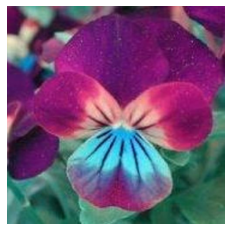

c:\Users\mashadservice\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


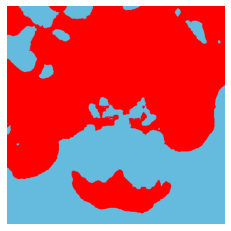

102


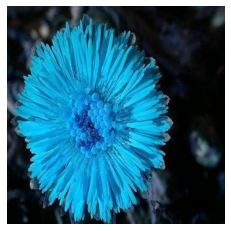

c:\Users\mashadservice\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


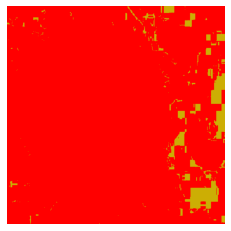

483


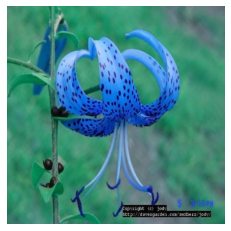

c:\Users\mashadservice\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


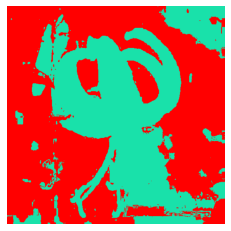

480


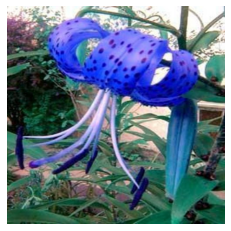

c:\Users\mashadservice\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


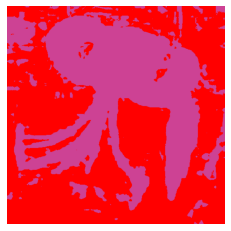

549


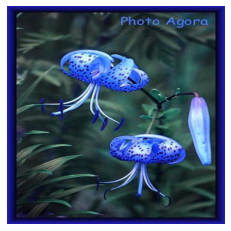

c:\Users\mashadservice\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


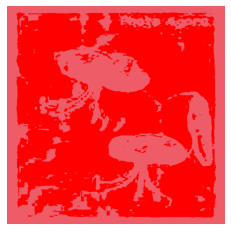

339


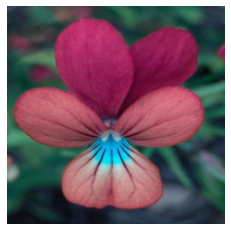

c:\Users\mashadservice\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


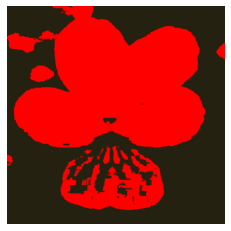

12


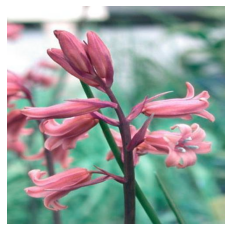

c:\Users\mashadservice\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


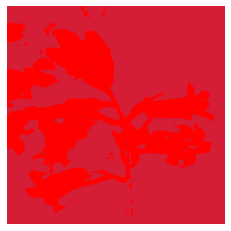

243


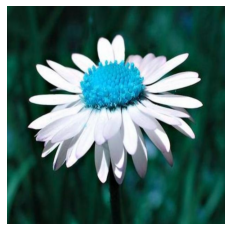

c:\Users\mashadservice\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


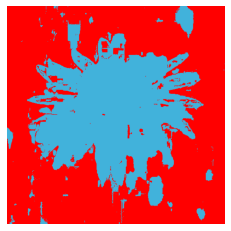

384


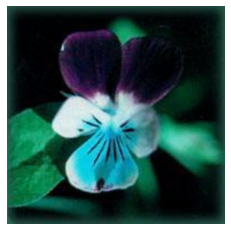

c:\Users\mashadservice\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


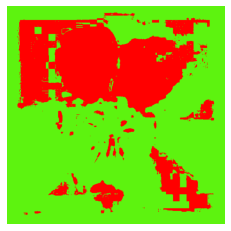

129


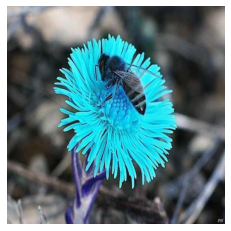

c:\Users\mashadservice\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


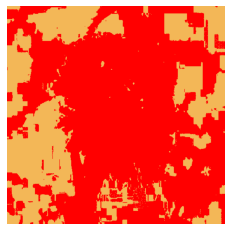

In [25]:

test_finding_flower(10)

# i = random.randrange(0, 490, 3)
# # i=15
# print(i)
# images2, _, features = load_dataset()
# show_image(images2[i])
# pixel_labels2,clusters,width,height,points_num= extract_flower_parts(features[i])
# flower_index = is_flower_cluster(clusters,width,height,points_num)
# show_cluster_image2(pixel_labels2,clusters[flower_index][0][5],width,height)
# feature_vector = calculate_circularity(clusters[flower_index])
# print(feature_vector)




In [25]:
classify(images2, labels2)

NameError: name 'classify' is not defined